<a href="https://colab.research.google.com/github/WayneGretzky1/nba_game_predictor/blob/main/FINAL_nba_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
torch.set_printoptions(sci_mode=False)

In [2]:
nba_df = pd.read_csv("https://raw.githubusercontent.com/WayneGretzky1/nba_game_predictor/refs/heads/main/cleaned_enriched.csv")
nba_df.head()

,gameid,gamedate,home_teamid,away_teamid,home_win,away_win,home_win_avg_prev5,away_win_avg_prev5,home_points_avg_prev5,away_points_avg_prev5,...,home_freethrowspercentage_avg_szn,away_freethrowspercentage_avg_szn,home_reboundstotal_avg_szn,away_reboundstotal_avg_szn,home_foulspersonal_avg_szn,away_foulspersonal_avg_szn,home_turnovers_avg_szn,away_turnovers_avg_szn,home_rest,away_rest
0,21600102,2016-11-08,1610612763,1610612743,True,False,0.6,0.6,97.0,104.0,...,0.7542,0.774600,47.200000,48.6,24.200000,20.400000,15.800000,17.8,True,True
1,21600144,2016-11-13,1610612757,1610612743,True,False,0.6,0.4,113.8,104.0,...,0.7860,0.777833,37.000000,47.0,24.000000,20.833333,15.600000,18.5,True,True
2,21600145,2016-11-14,1610612754,1610612753,True,False,0.8,0.4,115.4,96.6,...,0.7282,0.728400,42.800000,42.0,20.400000,18.800000,15.000000,13.0,True,False
3,21600148,2016-11-14,1610612740,1610612738,True,False,0.0,0.4,107.8,104.6,...,0.7284,0.709000,41.800000,39.0,20.200000,23.800000,11.600000,11.6,True,True
4,21600156,2016-11-15,1610612757,1610612741,False,True,0.6,0.4,113.6,103.4,...,0.7905,0.829600,38.166667,45.2,23.833333,17.400000,14.333333,16.6,True,True


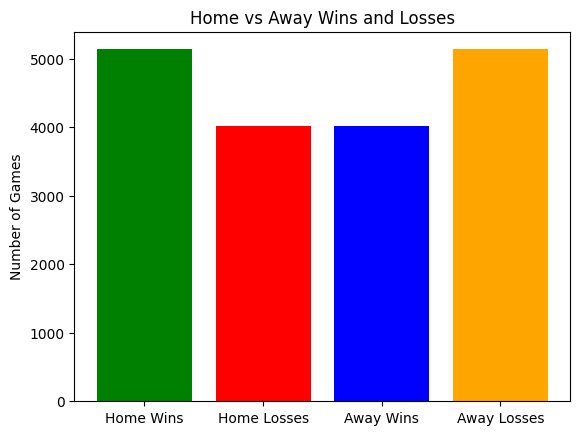

home_wins 5139
home_losses 4012
away_wins 4012
away_losses 5139


In [3]:
home_wins = nba_df['home_win'].sum()
home_losses = len(nba_df) - home_wins
away_wins = nba_df['away_win'].sum()
away_losses = len(nba_df) - away_wins

categories = ['Home Wins', 'Home Losses', 'Away Wins', 'Away Losses']
counts = [home_wins, home_losses, away_wins, away_losses]

plt.bar(categories, counts, color=['green', 'red', 'blue', 'orange'])
plt.title('Home vs Away Wins and Losses')
plt.ylabel('Number of Games')
plt.show()
print("home_wins", home_wins)
print("home_losses", home_losses)
print("away_wins", away_wins)
print("away_losses", away_losses)


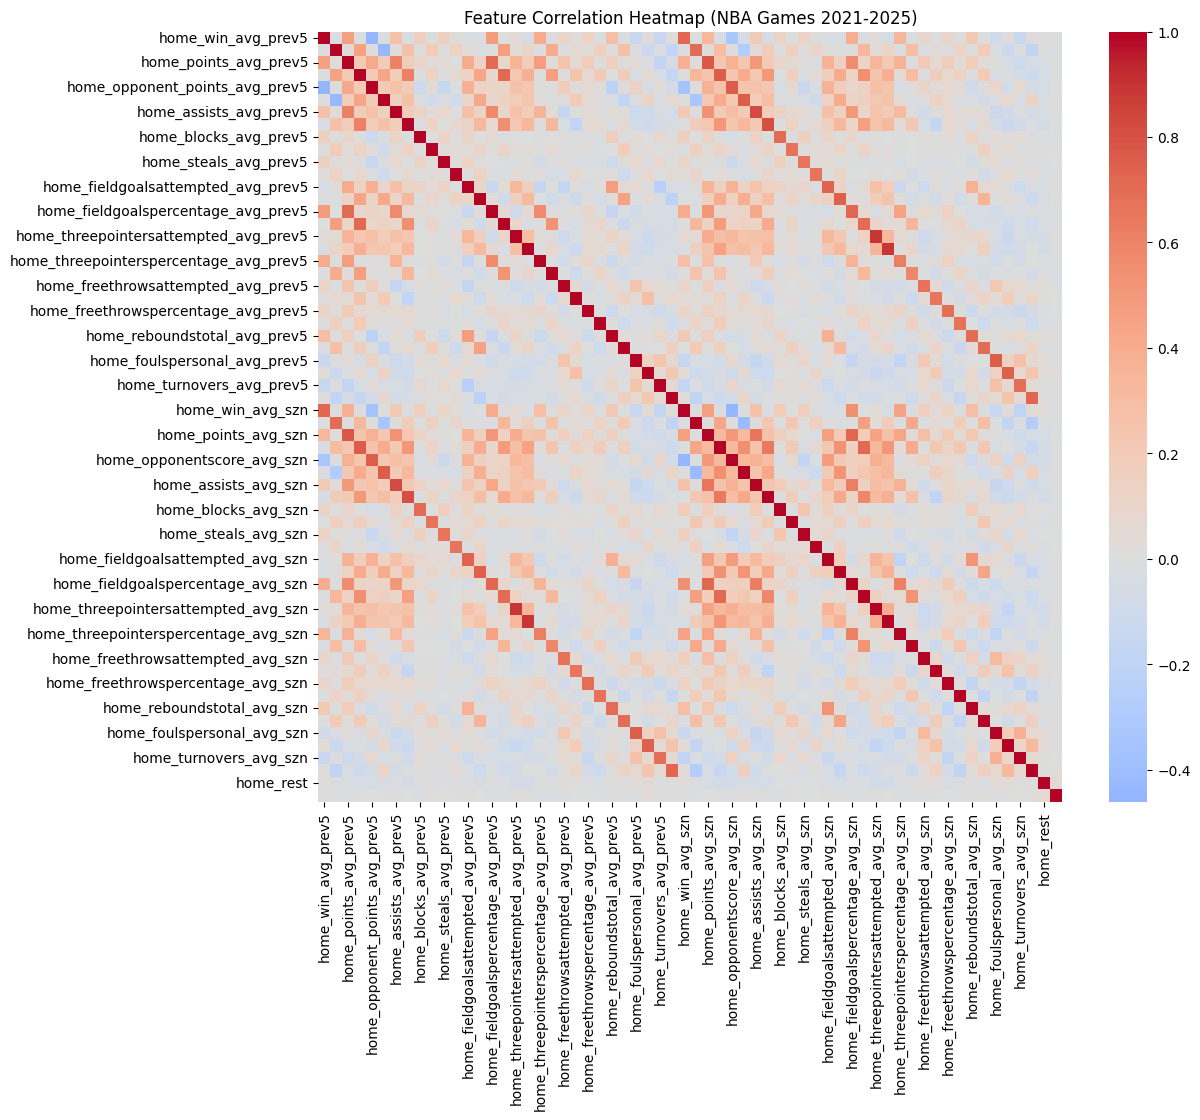

home_win                               1.000000
home_win_avg_szn                       0.233977
home_win_avg_prev5                     0.191366
home_fieldgoalspercentage_avg_szn      0.143956
home_fieldgoalspercentage_avg_prev5    0.125469
                                         ...   
away_fieldgoalspercentage_avg_szn     -0.106709
home_opponent_points_avg_prev5        -0.106931
home_opponentscore_avg_szn            -0.124116
away_win_avg_prev5                    -0.144821
away_win_avg_szn                      -0.187302
Name: home_win, Length: 63, dtype: float64


In [4]:
feature_df = nba_df.drop(columns=['home_win', 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid'])
corr_matrix = feature_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (NBA Games 2021-2025)")
plt.show()
# print(corr_matrix.round(3))
# strong_corr = corr_matrix[(corr_matrix.abs() > 0.5) & (corr_matrix.abs() < 1.0)]
# print(strong_corr.round(3))
feature_df = nba_df.drop(columns=[ 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid'])

label_corr = feature_df.corr()['home_win'].sort_values(ascending=False)
print(label_corr)


In [5]:
#choose features X and label y
X = nba_df.drop(columns=['home_win', 'away_win', 'gameid', 'gamedate', 'home_teamid', 'away_teamid']).to_numpy() #every col except these
y = nba_df['home_win'].to_numpy()

In [6]:
#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#normalize with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [8]:
#PyTorch Dataset class
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).long()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [9]:
#Convert to PyTorch Dataset
training_dataset = NumpyDataset(X_train_norm, y_train)
testing_dataset = NumpyDataset(X_test_norm, y_test)

In [10]:
def train(model, data_generator, loss_function, lambda_l2, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    l2_norm = (torch.norm(model.linear1.weight, 2) + torch.norm(model.linear2.weight, 2))
    loss = loss + lambda_l2 * l2_norm
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, data_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      avg_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  avg_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return avg_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, lambda_l2, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  best_loss = float('inf')

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, lambda_l2, optimizer)
    test_loss = test(model, testing_generator, loss_function)

    current_best = test_loss

    if current_best < best_loss:
        best_loss = current_best
        torch.save(model.state_dict(), "best_model.pt")

    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)
  print(f"\nFinal Best Loss: {best_loss:.4f}")


def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum().item()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [11]:
class Classifier_3Layers(nn.Module):
    def __init__(self, input_dim, numClasses=2):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 10)
        self.linear2 = nn.Linear(10, numClasses)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 0.6917, Test Loss: 0.6663
Epoch [6/30], Train Loss: 0.6321, Test Loss: 0.6302
Epoch [11/30], Train Loss: 0.6248, Test Loss: 0.6270
Epoch [16/30], Train Loss: 0.6204, Test Loss: 0.6258
Epoch [21/30], Train Loss: 0.6178, Test Loss: 0.6260
Epoch [26/30], Train Loss: 0.6139, Test Loss: 0.6260

Final Best Loss: 0.6251


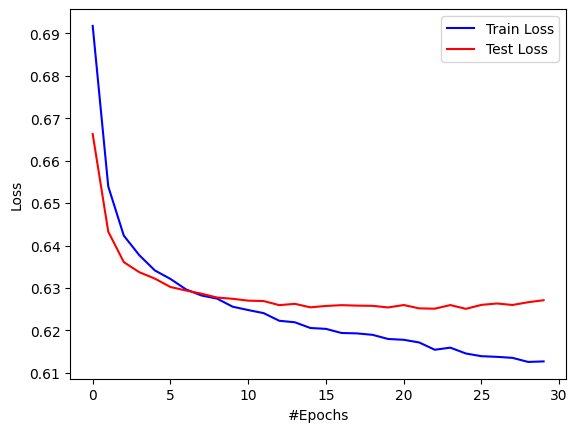

In [12]:
#Training parameters
num_epochs = 30
learning_rate = 0.001
batch_size = 200
lambda_l2 = 1e-5
print_interval = 5

input_dim = X_train_norm.shape[1]

#Create model
model = Classifier_3Layers(input_dim, numClasses=2)

#Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, lambda_l2, print_interval)

In [13]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 4888/7320 (66.8%)

Test Set: Accuracy: 1189/1831 (64.9%)


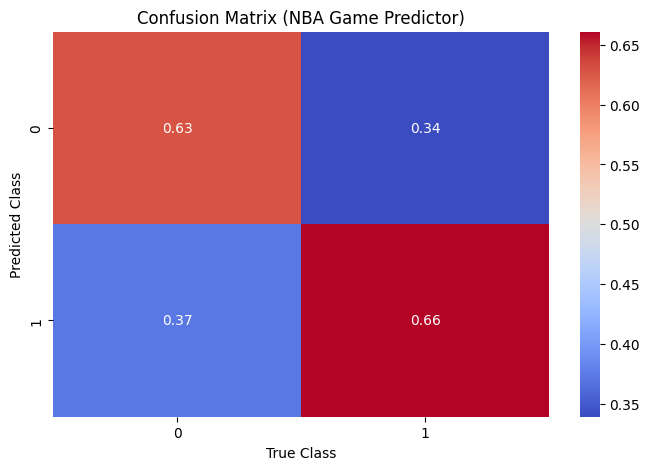

[[0.62772586 0.33894029]
 [0.37227414 0.66105971]]


In [14]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (features,labels) = next(data_enumerator)
with torch.no_grad():
    outputs = model(features)
    pred_labels = outputs.data.max(1, keepdim=True)[1].squeeze() #only the highest value is the final prediction
    true_labels = labels
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "coolwarm") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix (NBA Game Predictor)")
plt.show()
print(conf_mat)

In [15]:
y_true = true_labels.numpy()
y_pred = pred_labels.numpy()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.6610597140454163
Recall: 0.7668292682926829
F1-score: 0.7100271002710027


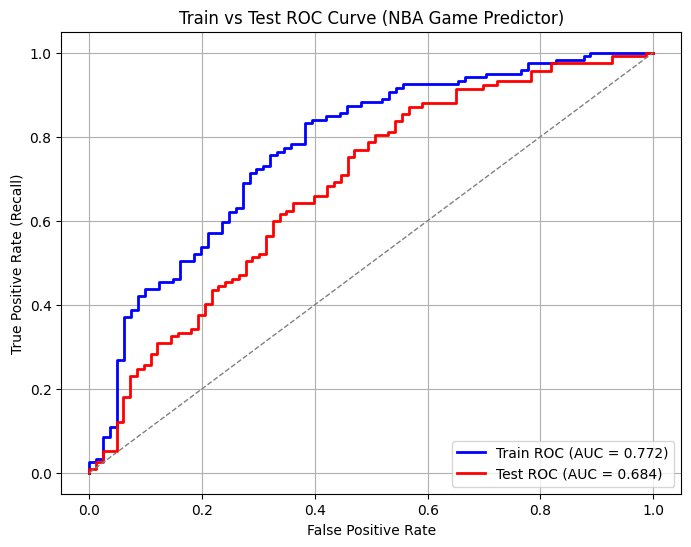

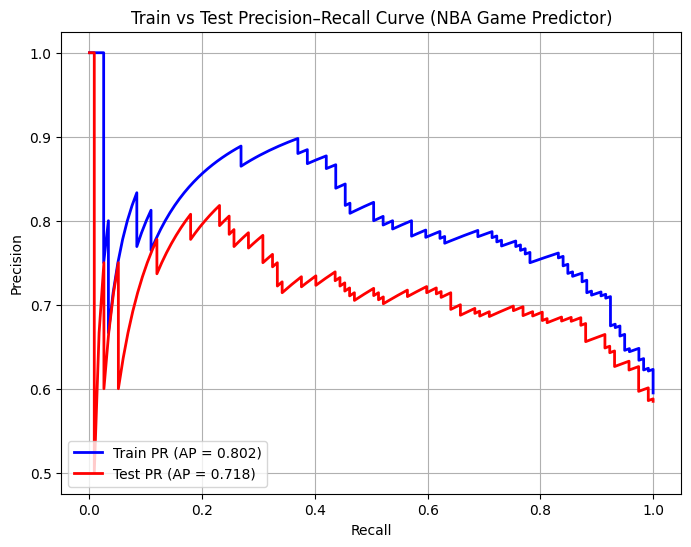

In [16]:
_, (train_features, train_labels) = next(enumerate(training_generator))
_, (test_features, test_labels) = next(enumerate(testing_generator))

with torch.no_grad():
    train_outputs = model(train_features)
    y_train_scores = torch.softmax(train_outputs, dim=1)[:,1].numpy()
    y_train_true = train_labels.numpy()

    test_outputs = model(test_features)
    y_test_scores = torch.softmax(test_outputs, dim=1)[:,1].numpy()
    y_test_true = test_labels.numpy()


fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Train vs Test ROC Curve (NBA Game Predictor)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

precision_train, recall_train, _ = precision_recall_curve(y_train_true, y_train_scores)
avg_precision_train = average_precision_score(y_train_true, y_train_scores)

precision_test, recall_test, _ = precision_recall_curve(y_test_true, y_test_scores)
avg_precision_test = average_precision_score(y_test_true, y_test_scores)

plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, color='blue', lw=2,
         label=f'Train PR (AP = {avg_precision_train:.3f})')
plt.plot(recall_test, precision_test, color='red', lw=2,
         label=f'Test PR (AP = {avg_precision_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train vs Test Precision–Recall Curve (NBA Game Predictor)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [17]:
class LinearClassifier(nn.Module):
    def __init__(self, features, numClasses):
        super().__init__()
        self.linear1 = nn.Linear(features, numClasses)

    def forward(self, x):
        x = self.linear1(x)
        return x

In [18]:
#PyTorch Dataset class
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [19]:
#Convert to PyTorch Dataset
training_dataset = NumpyDataset(X_train_norm, y_train)
testing_dataset = NumpyDataset(X_test_norm, y_test)

In [20]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data).flatten()                   # Forward pass: compute the output class given a image

    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

#Test
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data).flatten()
      test_loss += loss_function(output, target).item()
      pred = output.data.max()
      num_batches += 1
  test_loss /= num_batches
  return test_loss

#Log Results
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

#Graph the loss
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)
  plt.show()
  plt.close(fig) # Close the figure to free up memory

#Combine
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)


In [21]:
#Compute accuracy of model
def computeLabelAccuracy2(networkModel, data_loader, label_text=""):
  correct = 0
  total = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data).flatten()
      probs = torch.sigmoid(output) #get the probabilities of each output from the logit
      correct += ((probs > 0.5) == target).sum().item()
      total += target.size(0)
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))
  return 100. * correct / len(data_loader.dataset)

In [22]:
#Tune epochs, learning rate, batch size, and weight decay
def LogisticRegressionModel(num_epochs, lr, batch_size, wd, train, test):
  predModel = LinearClassifier(X_train_norm.shape[1],1)

  model = predModel;
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) #weight decays [0.1, 0.01, 0.001, ]
  loss_function = torch.nn.BCEWithLogitsLoss()

  training_generator = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  testing_generator = torch.utils.data.DataLoader(test, batch_size=batch_size)

  print("Loaded Data")

  trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, lr, 10000)
  train_acc = computeLabelAccuracy2(model, training_generator, "Training")
  test_acc = computeLabelAccuracy2(model, testing_generator, "Testing")

  return train_acc, test_acc

Loaded Data
Epoch [1/30], Train Loss: 7.0000, Test Loss: 3.8672

Training: Accuracy: 4654/7320 (63.6%)

Testing: Accuracy: 1169/1831 (63.8%)
63.844893500819225
Loaded Data
Epoch [1/30], Train Loss: 2.7055, Test Loss: 0.9598

Training: Accuracy: 3341/7321 (45.6%)

Testing: Accuracy: 819/1830 (44.8%)
44.75409836065574
Loaded Data
Epoch [1/30], Train Loss: 3.3849, Test Loss: 1.4822

Training: Accuracy: 4444/7321 (60.7%)

Testing: Accuracy: 1071/1830 (58.5%)
58.52459016393443
Loaded Data
Epoch [1/30], Train Loss: 3.8497, Test Loss: 0.9689

Training: Accuracy: 4145/7321 (56.6%)

Testing: Accuracy: 1006/1830 (55.0%)
54.97267759562842
Loaded Data
Epoch [1/30], Train Loss: 3.7908, Test Loss: 1.0257

Training: Accuracy: 4726/7321 (64.6%)

Testing: Accuracy: 1140/1830 (62.3%)
62.295081967213115
Loaded Data
Epoch [1/90], Train Loss: 39.3724, Test Loss: 13.3105

Training: Accuracy: 3207/7320 (43.8%)

Testing: Accuracy: 806/1831 (44.0%)
44.0196613872201
Loaded Data
Epoch [1/90], Train Loss: 23.7718

/tmp/ipython-input-1063304262.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



Training: Accuracy: 4114/7320 (56.2%)

Testing: Accuracy: 1025/1831 (56.0%)
55.9803386127799
Loaded Data
Epoch [1/100], Train Loss: 48.7361, Test Loss: 8.7747

Training: Accuracy: 4093/7321 (55.9%)

Testing: Accuracy: 1046/1830 (57.2%)
57.15846994535519
Loaded Data
Epoch [1/100], Train Loss: 36.0222, Test Loss: 38.4217

Training: Accuracy: 4104/7321 (56.1%)

Testing: Accuracy: 1035/1830 (56.6%)
56.557377049180324
Loaded Data
Epoch [1/100], Train Loss: 47.7657, Test Loss: 16.8083

Training: Accuracy: 3191/7321 (43.6%)

Testing: Accuracy: 829/1830 (45.3%)
45.30054644808743
Loaded Data
Epoch [1/100], Train Loss: 49.3184, Test Loss: 14.9977

Training: Accuracy: 4109/7321 (56.1%)

Testing: Accuracy: 1030/1830 (56.3%)
56.28415300546448
Loaded Data
Epoch [1/10], Train Loss: 21.2075, Test Loss: 17.2733

Training: Accuracy: 4114/7320 (56.2%)

Testing: Accuracy: 1025/1831 (56.0%)
55.9803386127799
Loaded Data
Epoch [1/10], Train Loss: 14.5448, Test Loss: 8.7593

Training: Accuracy: 3403/7321 (46

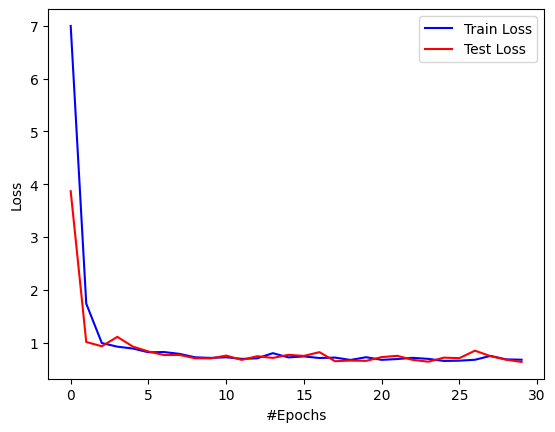

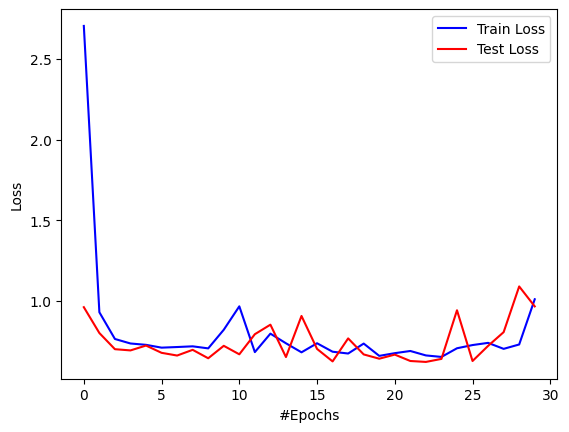

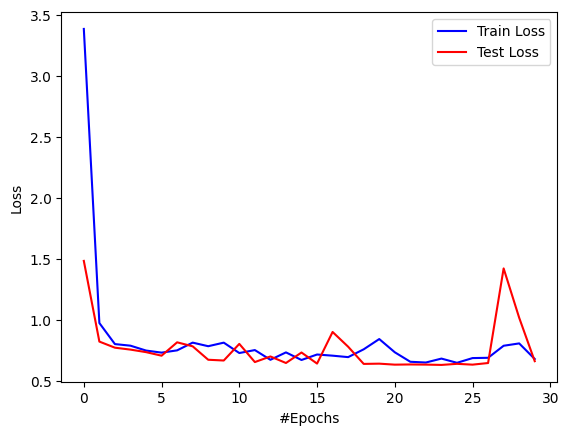

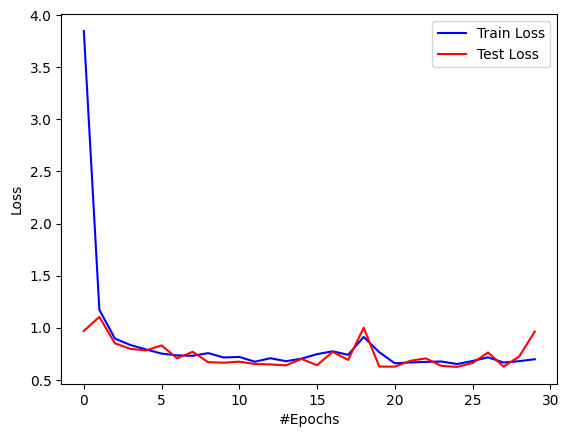

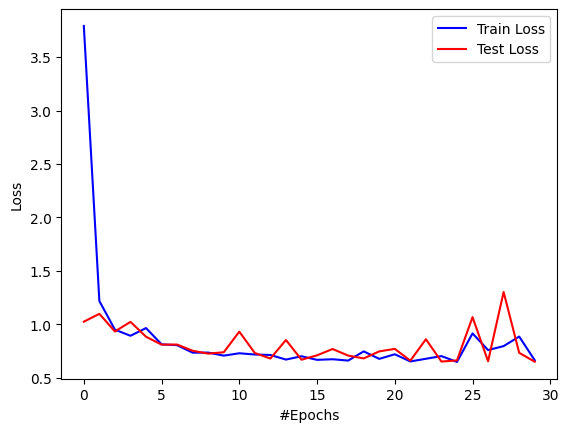

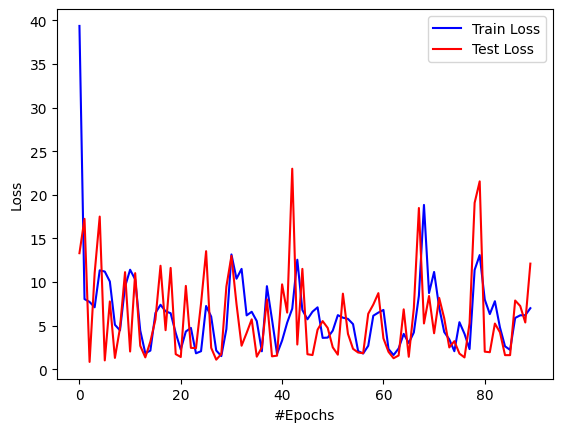

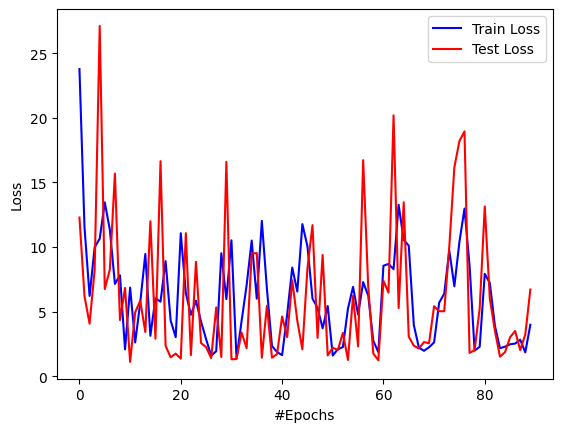

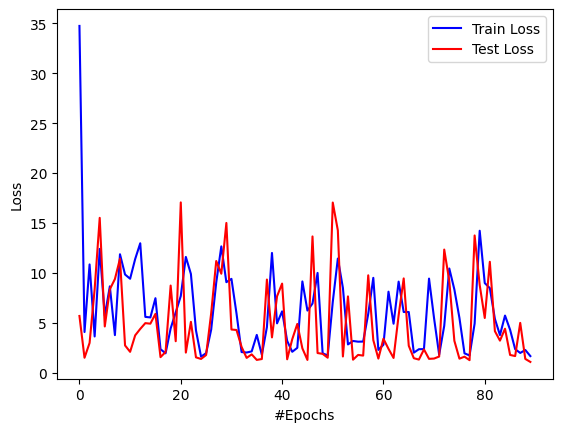

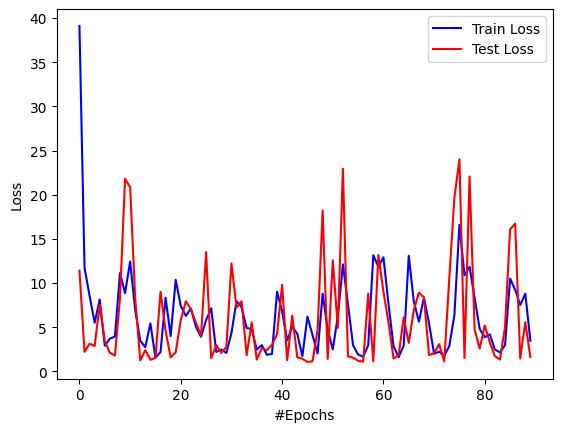

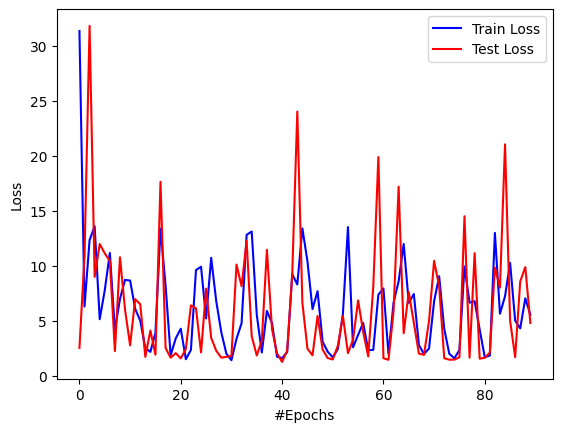

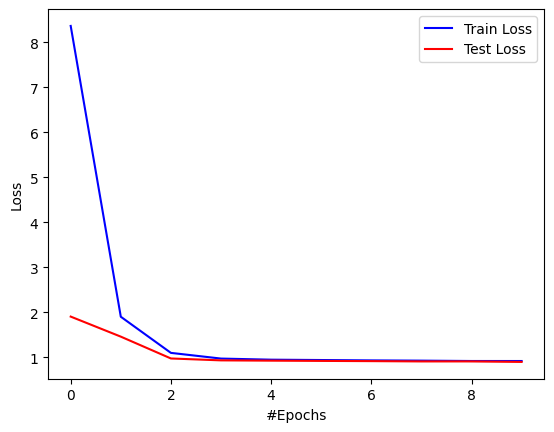

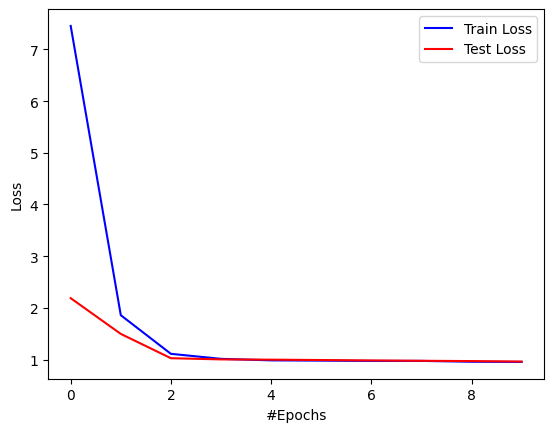

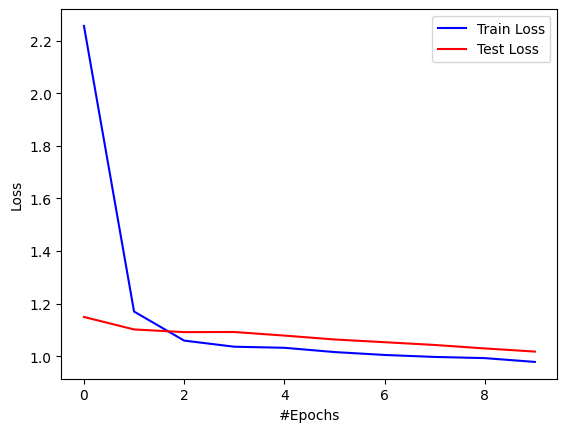

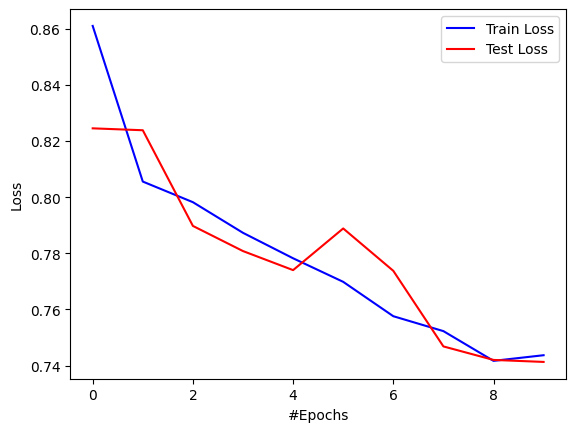

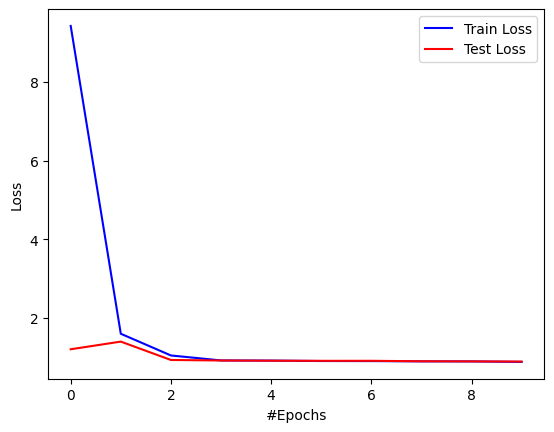

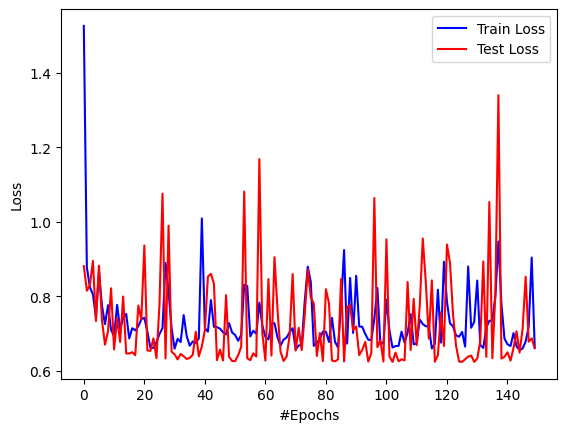

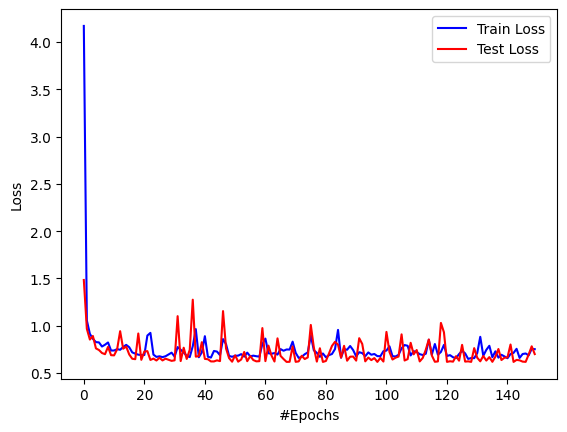

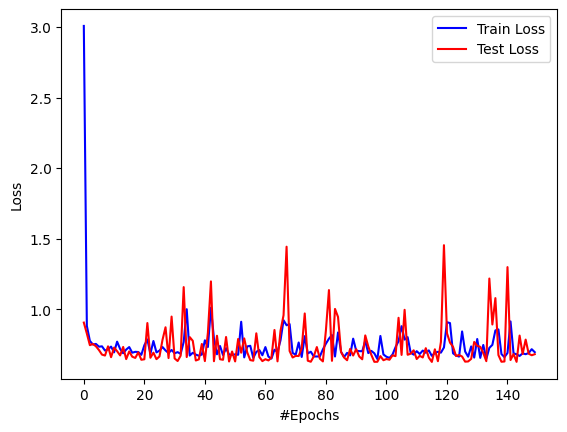

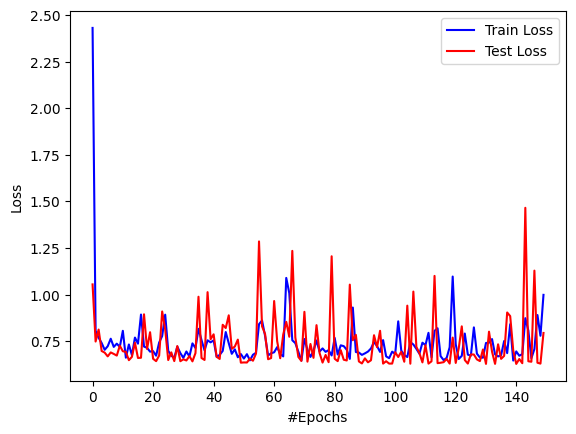

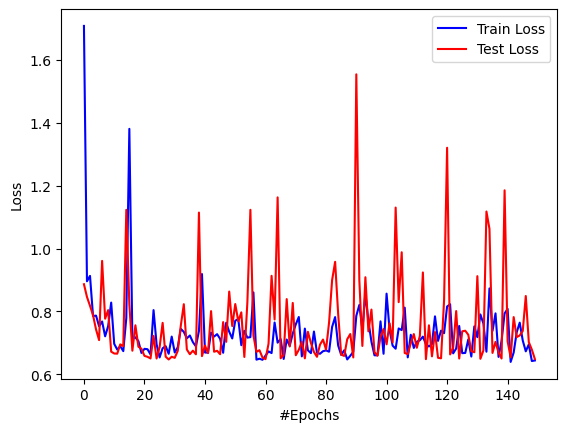

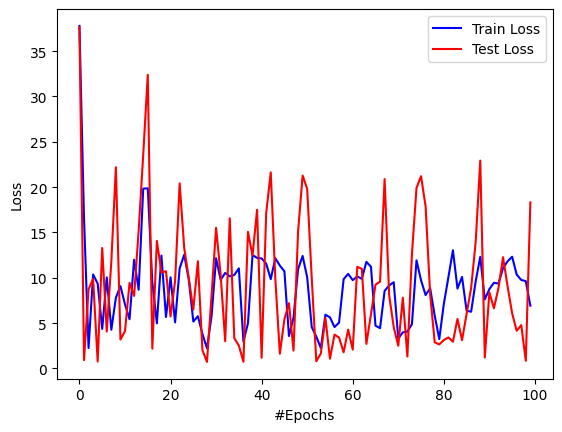

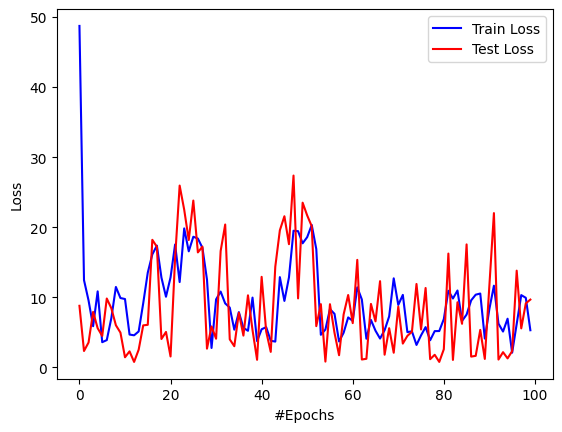

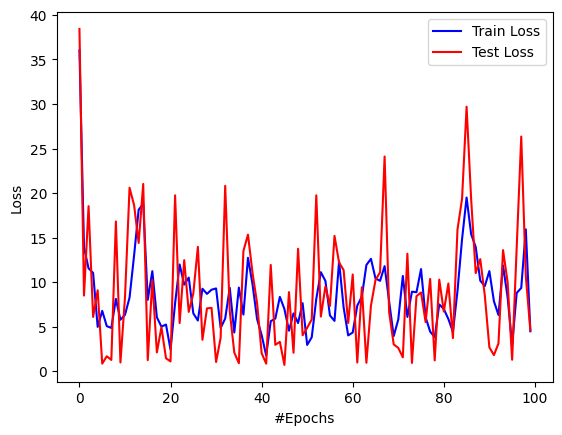

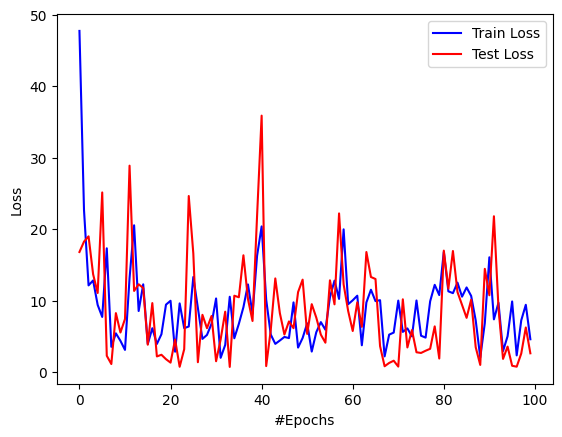

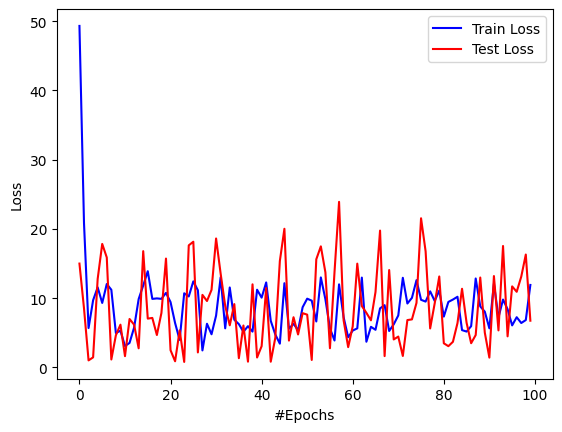

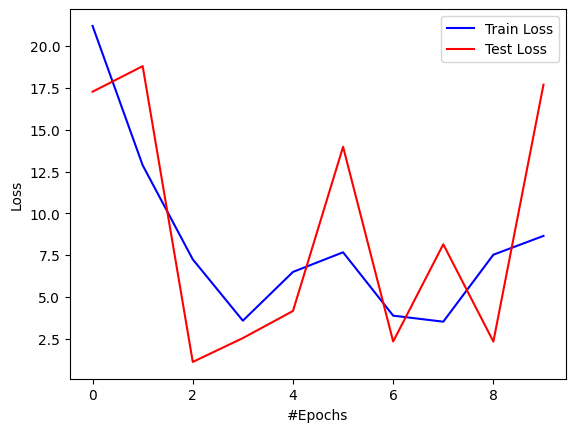

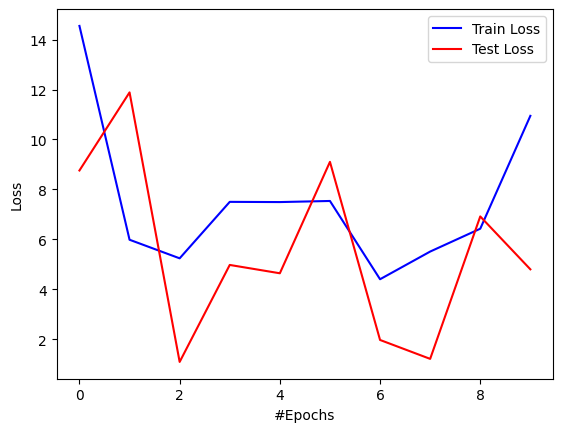

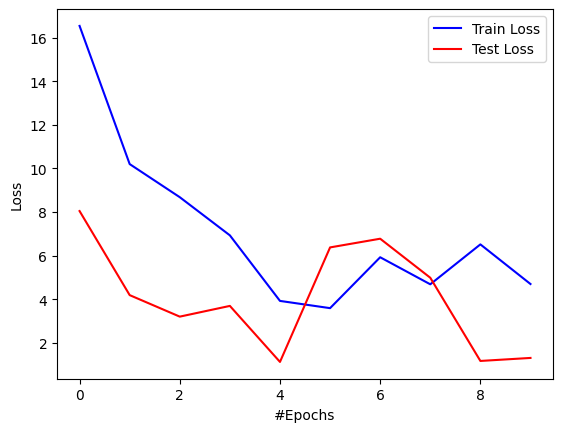

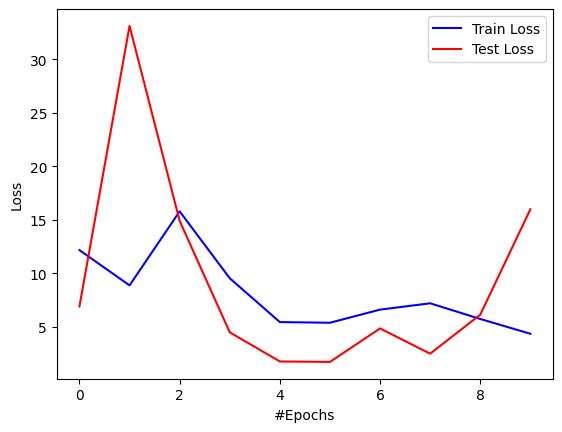

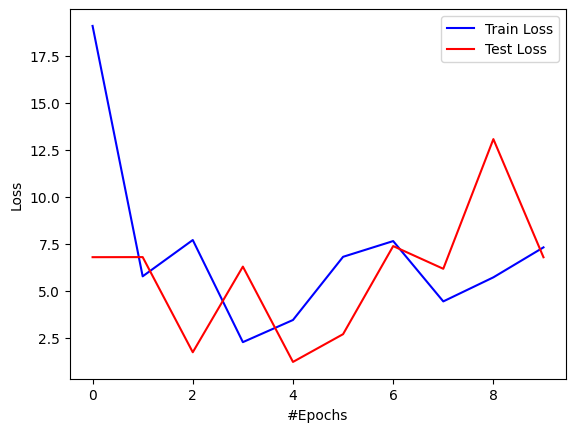

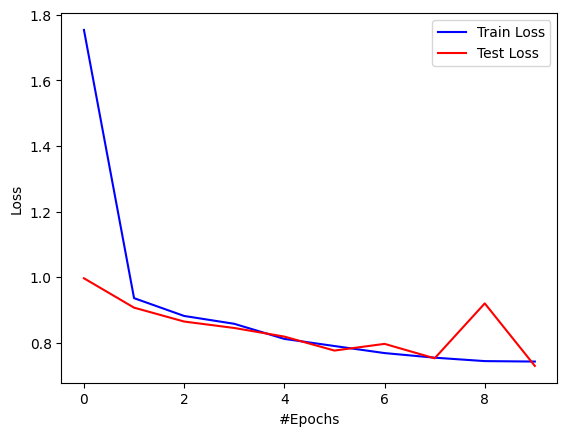

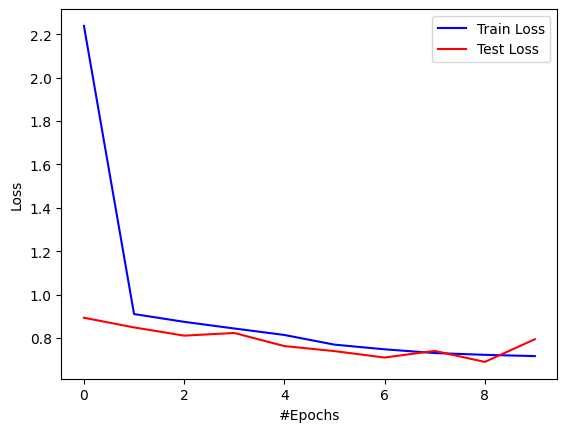

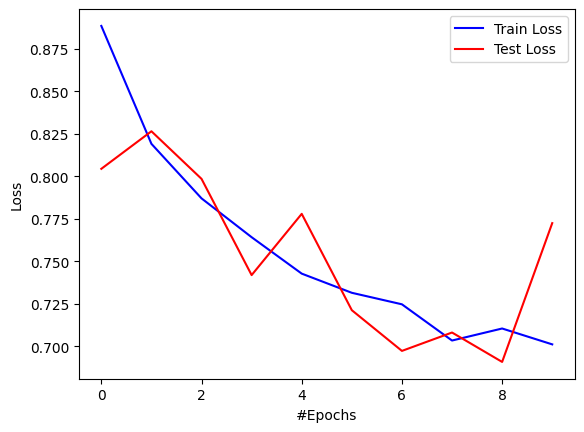

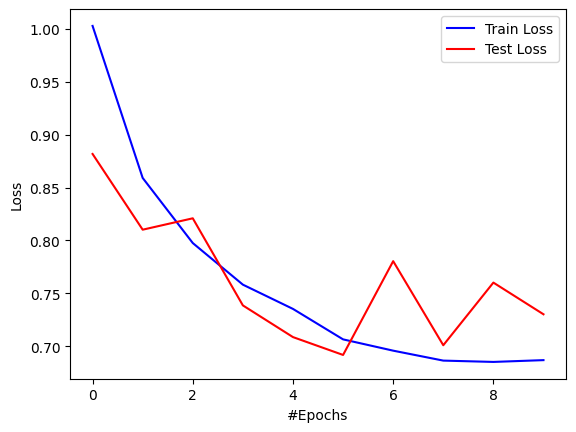

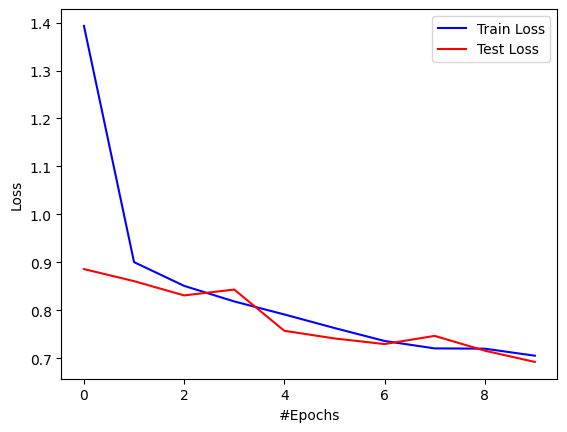

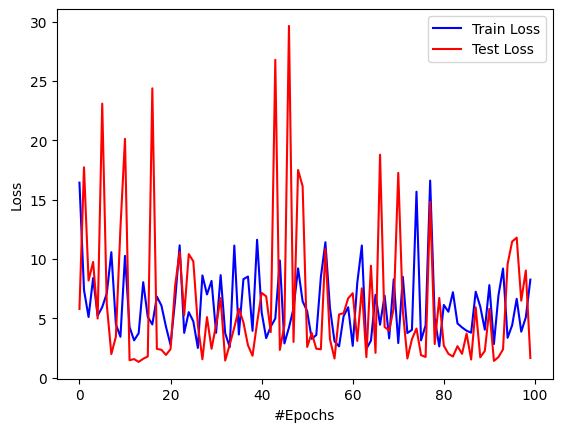

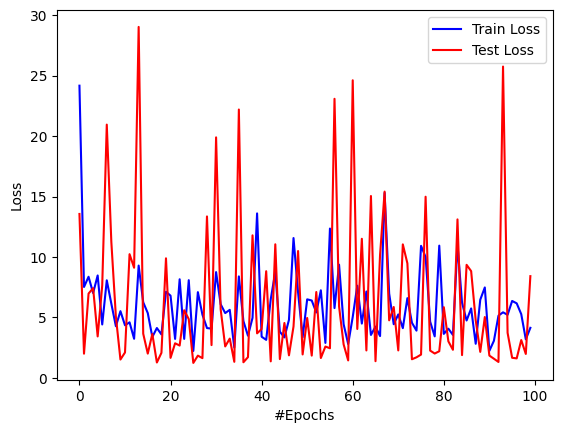

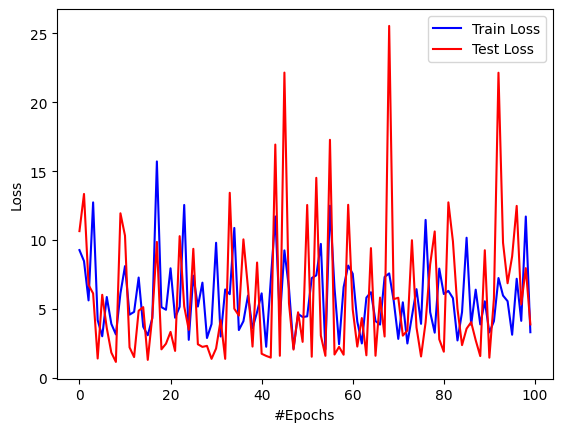

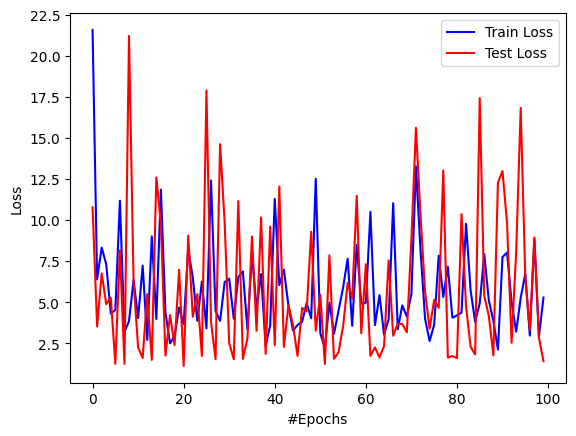

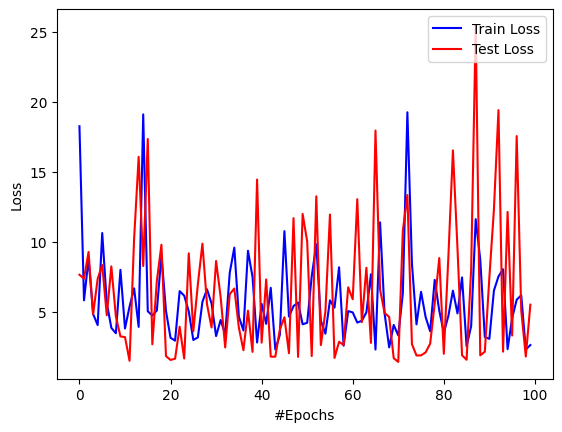

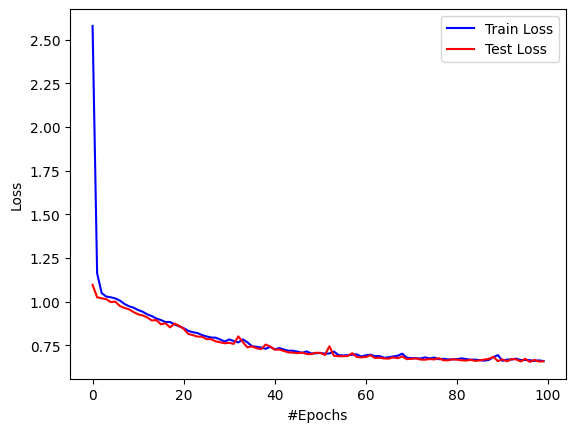

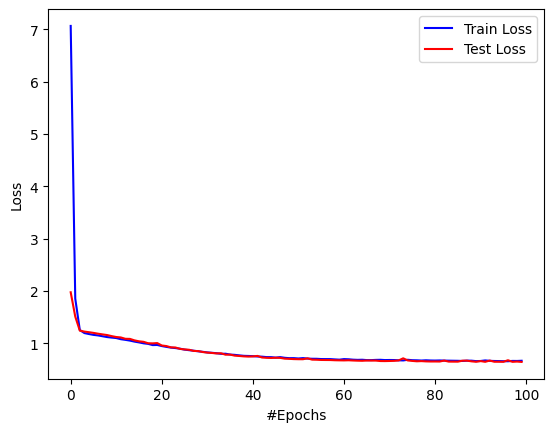

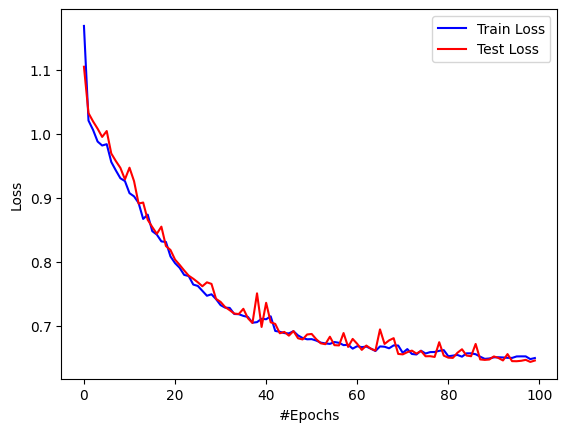

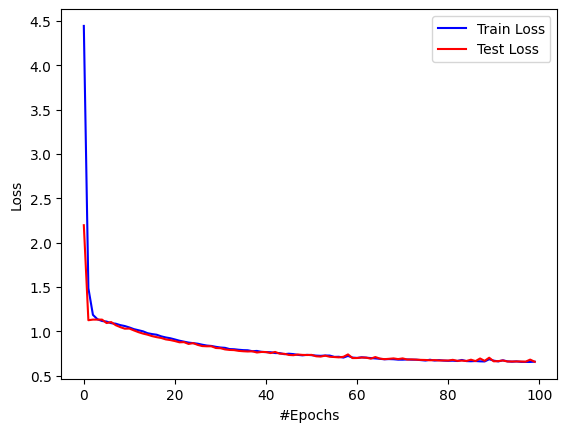

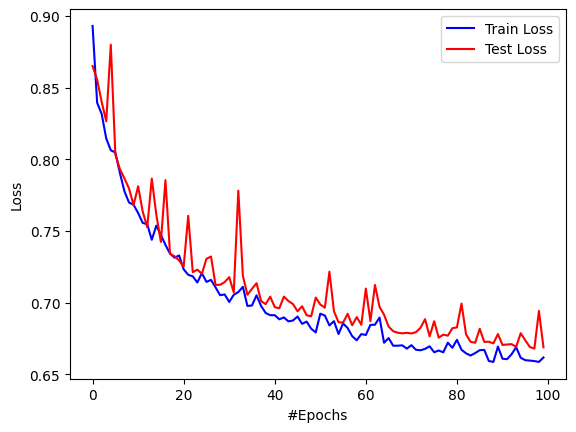

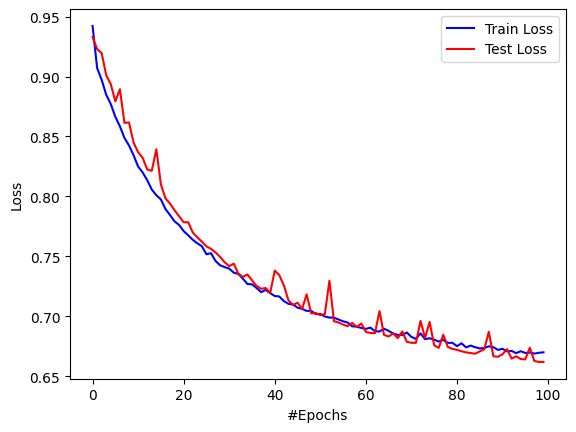

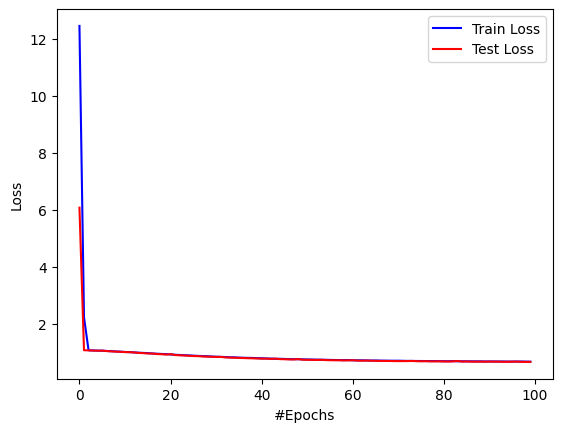

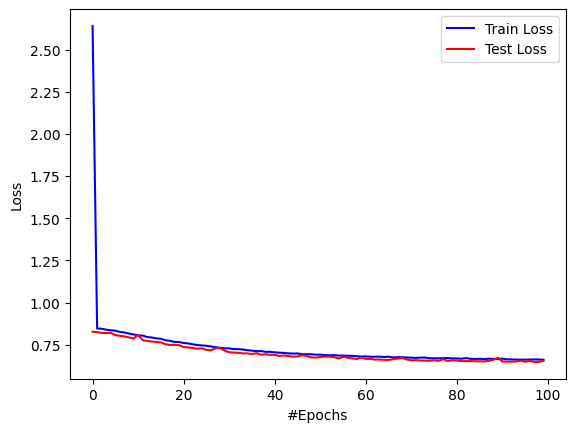

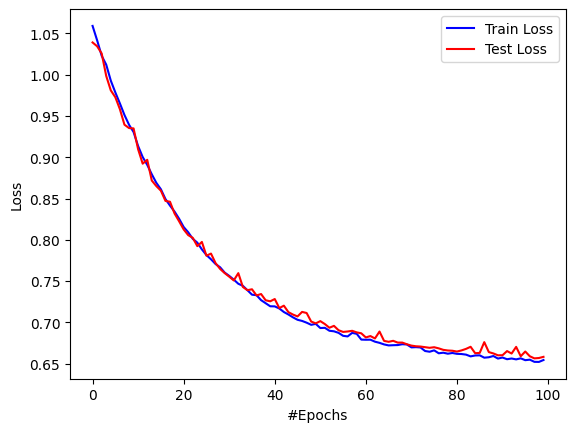

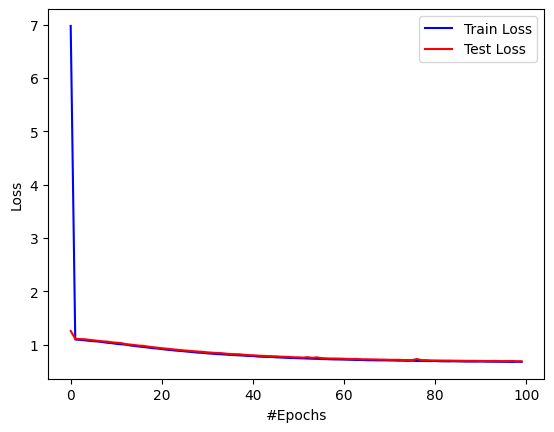

In [26]:
#Hyperparameters to test
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
decs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [50, 100, 200, 300, 400, 500]
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150]
from sklearn.model_selection import KFold, cross_val_score

#randomized search with cross validation
import random
all_avg_accs = [] #avg accuracy of each iteration
iter = 0
for i in range(10):
  lr = random.choice(lrs)
  dec = random.choice(decs)
  bs = random.choice(batch_sizes)
  e = random.choice(epochs)

  #IMPLEMENT CROSS VAL
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = [] #each accuracy
  for train_idx, test_idx in kf.split(X):
    x_train2 = X[train_idx].astype(np.float32) # Convert to float32
    y_train2 = y[train_idx].astype(np.float32) # Convert to float32
    x_test2 = X[test_idx].astype(np.float32)   # Convert to float32
    y_test2 = y[test_idx].astype(np.float32)   # Convert to float32
    x_dataset = NumpyDataset(x_train2, y_train2)
    y_dataset = NumpyDataset(x_test2, y_test2)
    train_acc, test_acc = LogisticRegressionModel(e,lr, bs, dec, x_dataset, y_dataset)
    scores.append(test_acc)
    print(test_acc)
  iter += 1
  avg_acc = np.mean(scores) #avg accuracy of the iteration
  all_avg_accs.append({"iter": iter, "avg_acc": avg_acc, "e": e, "lr": lr, "bs": bs, "wd": dec})
  # print(f"iteration {iter} with e: {e}, lrd: {lr}, bs: {bs}, dec: {dec}")
for acc in all_avg_accs:
  print(acc)


Loaded Data
Epoch [1/100], Train Loss: 0.7286, Test Loss: 0.7039
Epoch [11/100], Train Loss: 0.6338, Test Loss: 0.6296
Epoch [21/100], Train Loss: 0.6303, Test Loss: 0.6238
Epoch [31/100], Train Loss: 0.6303, Test Loss: 0.6226
Epoch [41/100], Train Loss: 0.6284, Test Loss: 0.6222
Epoch [51/100], Train Loss: 0.6301, Test Loss: 0.6224
Epoch [61/100], Train Loss: 0.6272, Test Loss: 0.6224
Epoch [71/100], Train Loss: 0.6282, Test Loss: 0.6225
Epoch [81/100], Train Loss: 0.6292, Test Loss: 0.6224
Epoch [91/100], Train Loss: 0.6316, Test Loss: 0.6227

Training: Accuracy: 4684/7320 (64.0%)

Testing: Accuracy: 1203/1831 (65.7%)


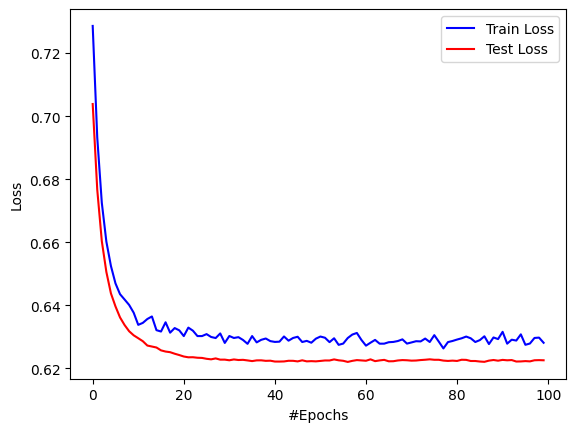

In [28]:
#Use the tuned hyperparameters
predModel = LinearClassifier(X_train_norm.shape[1],1)

model = predModel;
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = torch.nn.BCEWithLogitsLoss()

training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=400, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=400)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, 100, 0.001, 10)
train_acc = computeLabelAccuracy2(model, training_generator, "Training")
test_acc = computeLabelAccuracy2(model, testing_generator, "Testing")

AUC: 0.7026835320462386
Precision [0.63862928 0.66694701]
Recall [0.50868486 0.77365854]
F1 [0.56629834 0.7163505 ]
Count [ 806 1025]


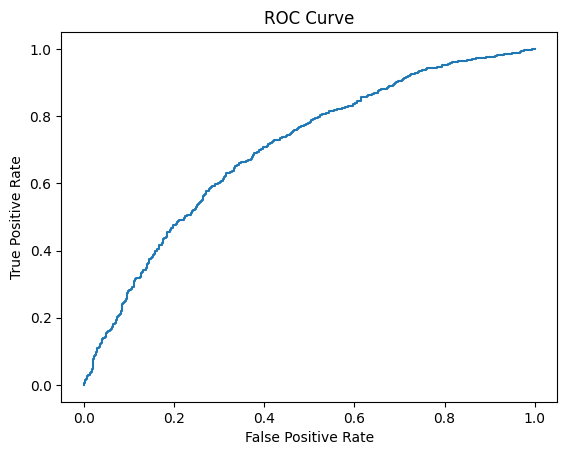

In [29]:
from sklearn import metrics
preds = model(torch.tensor(X_test_norm).float())
# print(preds)
probs = torch.sigmoid(preds).detach().numpy() #convert to probabilities
# print(probs)
y_pred = (probs >= 0.5)
# print(X_test.shape)
# print(y_test.shape)
# print(preds)
fpr, tpr, thresholds = metrics.roc_curve(y_test,probs)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(y_test, y_pred)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

In [35]:
#pre-trained model
import huggingface_hub
huggingface_hub.login()

In [31]:
!pip install tabpfn
!pip install --upgrade tabpfn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [37]:
#implement pre-trained model for extra credit
from sklearn.metrics import accuracy_score
from tabpfn import TabPFNClassifier

clf = TabPFNClassifier(ignore_pretraining_limits=True)
clf.fit(X_train_norm, y_train)

preds = clf.predict(X_test_norm)
print("Accuracy", accuracy_score(y_test, preds))

Accuracy 0.6597487711632988


In [39]:
pre_f1 = f1_score(y_test, preds)
pre_recall = recall_score(y_test, preds)
pre_precision = precision_score(y_test, preds)
print("Precision:", pre_precision)
print("Recall:", pre_recall)
print("F1-score:", pre_f1)

Precision: 0.6703389830508475
Recall: 0.7717073170731708
F1-score: 0.7174603174603175
